### 什么是条件变分自编码器CVAE ？
参考论文：《计算机学报》2019.1  自编码神经网络理论及应用综述  袁非牛    
变分自编码器只能产生与训练数据相似的输出，如果要想实现生成某一类图像，就用到条件变分自编码器了。 
主要做法：是在训练、测试时，加入一个one-hot向量，用于表示标签向量。其实，就是给编码和解码部分加了一个条件，让网络学习图片分布时加入了标签因素，这样可以按照标签的数值来生成指定的图片。

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms


In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

In [4]:
# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 50
batch_size = 128

# Architecture
num_classes = 10
num_features = 784
num_hidden_1 = 500
num_latent = 35

In [5]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

In [6]:
def to_onehot(labels, num_classes, device):

    labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)

    return labels_onehot

In [7]:
class ConditionalVariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_latent, num_classes):
        super(ConditionalVariationalAutoencoder, self).__init__()
        
        self.num_classes = num_classes
        
        ### ENCODER: 这里添加了标签信息
        self.hidden_1 = torch.nn.Linear(num_features+num_classes, num_hidden_1)
        self.z_mean = torch.nn.Linear(num_hidden_1, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use 
        # an exponential function
        self.z_log_var = torch.nn.Linear(num_hidden_1, num_latent)
        
        
        ### DECODER
        self.linear_3 = torch.nn.Linear(num_latent+num_classes, num_hidden_1)
        self.linear_4 = torch.nn.Linear(num_hidden_1, num_features+num_classes)

    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features, targets):
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        x = torch.cat((features, onehot_targets), dim=1)

        ### ENCODER
        x = self.hidden_1(x)
        x = F.leaky_relu(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded, targets):
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        encoded = torch.cat((encoded, onehot_targets), dim=1)        
        
        ### DECODER
        x = self.linear_3(encoded)
        x = F.leaky_relu(x)
        x = self.linear_4(x)
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features, targets):
        
        z_mean, z_log_var, encoded = self.encoder(features, targets)
        decoded = self.decoder(encoded, targets)
        
        return z_mean, z_log_var, encoded, decoded


In [8]:
torch.manual_seed(random_seed)
model = ConditionalVariationalAutoencoder(num_features,
                                          num_hidden_1,
                                          num_latent,
                                          num_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = model(features, targets)

        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        
        # add condition
        x_con = torch.cat((features, to_onehot(targets, num_classes, device)), dim=1)
        
        pixelwise_bce = F.binary_cross_entropy(decoded, x_con, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader)//batch_size, cost))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 000/003 | Cost: 71038.6484
Epoch: 001/050 | Batch 050/003 | Cost: 27685.6777
Epoch: 001/050 | Batch 100/003 | Cost: 22469.4863
Epoch: 001/050 | Batch 150/003 | Cost: 20540.1270
Epoch: 001/050 | Batch 200/003 | Cost: 19664.3125
Epoch: 001/050 | Batch 250/003 | Cost: 18055.5840
Epoch: 001/050 | Batch 300/003 | Cost: 18197.2383
Epoch: 001/050 | Batch 350/003 | Cost: 17148.4238
Epoch: 001/050 | Batch 400/003 | Cost: 17092.0352
Epoch: 001/050 | Batch 450/003 | Cost: 16479.4453
Time elapsed: 0.39 min
Epoch: 002/050 | Batch 000/003 | Cost: 16541.3184
Epoch: 002/050 | Batch 050/003 | Cost: 15908.2773
Epoch: 002/050 | Batch 100/003 | Cost: 15621.6270
Epoch: 002/050 | Batch 150/003 | Cost: 15628.8223
Epoch: 002/050 | Batch 200/003 | Cost: 15230.4336
Epoch: 002/050 | Batch 250/003 | Cost: 15587.4131
Epoch: 002/050 | Batch 300/003 | Cost: 14549.4297
Epoch: 002/050 | Batch 350/003 | Cost: 15086.2305
Epoch: 002/050 | Batch 400/003 | Cost: 14816.6875
Epoch: 002/050 | Batch 450/

Epoch: 016/050 | Batch 300/003 | Cost: 12940.7090
Epoch: 016/050 | Batch 350/003 | Cost: 12386.0312
Epoch: 016/050 | Batch 400/003 | Cost: 12590.7783
Epoch: 016/050 | Batch 450/003 | Cost: 12163.5488
Time elapsed: 7.00 min
Epoch: 017/050 | Batch 000/003 | Cost: 12958.1504
Epoch: 017/050 | Batch 050/003 | Cost: 12481.9854
Epoch: 017/050 | Batch 100/003 | Cost: 12965.8730
Epoch: 017/050 | Batch 150/003 | Cost: 12898.7705
Epoch: 017/050 | Batch 200/003 | Cost: 12359.1992
Epoch: 017/050 | Batch 250/003 | Cost: 12932.5830
Epoch: 017/050 | Batch 300/003 | Cost: 12375.0322
Epoch: 017/050 | Batch 350/003 | Cost: 12694.3613
Epoch: 017/050 | Batch 400/003 | Cost: 12335.5137
Epoch: 017/050 | Batch 450/003 | Cost: 12858.3105
Time elapsed: 7.45 min
Epoch: 018/050 | Batch 000/003 | Cost: 12523.2266
Epoch: 018/050 | Batch 050/003 | Cost: 12512.3281
Epoch: 018/050 | Batch 100/003 | Cost: 12446.1875
Epoch: 018/050 | Batch 150/003 | Cost: 12819.5068
Epoch: 018/050 | Batch 200/003 | Cost: 12688.6045
Epoc

Epoch: 032/050 | Batch 100/003 | Cost: 12261.6484
Epoch: 032/050 | Batch 150/003 | Cost: 13233.5312
Epoch: 032/050 | Batch 200/003 | Cost: 12911.6396
Epoch: 032/050 | Batch 250/003 | Cost: 12949.2510
Epoch: 032/050 | Batch 300/003 | Cost: 12363.9678
Epoch: 032/050 | Batch 350/003 | Cost: 13179.8916
Epoch: 032/050 | Batch 400/003 | Cost: 12450.4414
Epoch: 032/050 | Batch 450/003 | Cost: 12536.8623
Time elapsed: 15.11 min
Epoch: 033/050 | Batch 000/003 | Cost: 12468.5459
Epoch: 033/050 | Batch 050/003 | Cost: 12589.9023
Epoch: 033/050 | Batch 100/003 | Cost: 11817.1582
Epoch: 033/050 | Batch 150/003 | Cost: 12877.8555
Epoch: 033/050 | Batch 200/003 | Cost: 12294.8418
Epoch: 033/050 | Batch 250/003 | Cost: 12441.2412
Epoch: 033/050 | Batch 300/003 | Cost: 12879.8906
Epoch: 033/050 | Batch 350/003 | Cost: 12345.8545
Epoch: 033/050 | Batch 400/003 | Cost: 12714.1758
Epoch: 033/050 | Batch 450/003 | Cost: 12409.5830
Time elapsed: 15.66 min
Epoch: 034/050 | Batch 000/003 | Cost: 12660.3906
Ep

Epoch: 047/050 | Batch 400/003 | Cost: 12583.9199
Epoch: 047/050 | Batch 450/003 | Cost: 12747.7930
Time elapsed: 24.27 min
Epoch: 048/050 | Batch 000/003 | Cost: 12947.2930
Epoch: 048/050 | Batch 050/003 | Cost: 12680.4609
Epoch: 048/050 | Batch 100/003 | Cost: 11982.9990
Epoch: 048/050 | Batch 150/003 | Cost: 12110.8652
Epoch: 048/050 | Batch 200/003 | Cost: 11571.6250
Epoch: 048/050 | Batch 250/003 | Cost: 12527.5225
Epoch: 048/050 | Batch 300/003 | Cost: 12148.2568
Epoch: 048/050 | Batch 350/003 | Cost: 12858.0020
Epoch: 048/050 | Batch 400/003 | Cost: 12765.0312
Epoch: 048/050 | Batch 450/003 | Cost: 12147.0566
Time elapsed: 24.86 min
Epoch: 049/050 | Batch 000/003 | Cost: 12411.3887
Epoch: 049/050 | Batch 050/003 | Cost: 12395.3477
Epoch: 049/050 | Batch 100/003 | Cost: 12380.4541
Epoch: 049/050 | Batch 150/003 | Cost: 12813.1582
Epoch: 049/050 | Batch 200/003 | Cost: 12021.2012
Epoch: 049/050 | Batch 250/003 | Cost: 12273.2871
Epoch: 049/050 | Batch 300/003 | Cost: 12205.4199
Ep

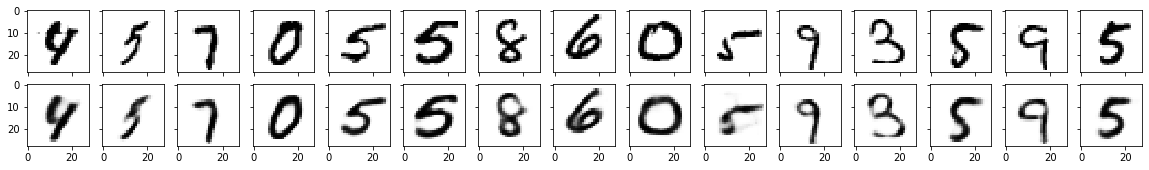

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images][:, :-num_classes]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

Class Label 0


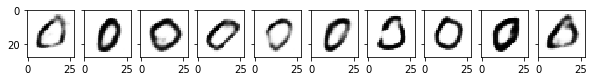

Class Label 1


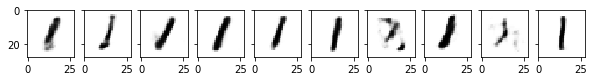

Class Label 2


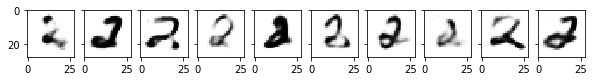

Class Label 3


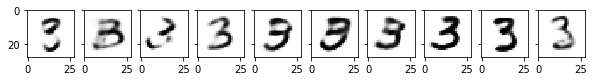

Class Label 4


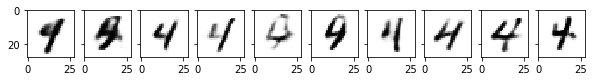

Class Label 5


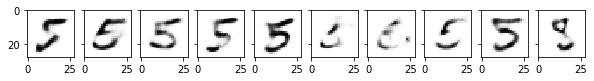

Class Label 6


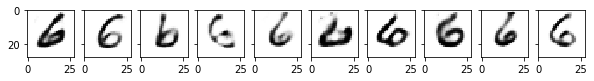

Class Label 7


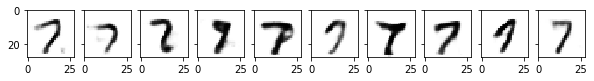

Class Label 8


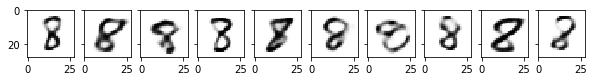

Class Label 9


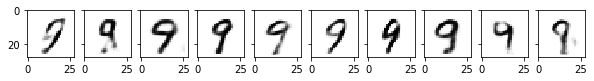

In [11]:
for i in range(10):

    ##########################
    ### RANDOM SAMPLE
    ##########################    
    
    labels = torch.tensor([i]*10).to(device)
    n_images = labels.size()[0]
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features, labels)

    ##########################
    ### VISUALIZATION
    ##########################

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images][:, :-num_classes]

    print('Class Label %d' % i)

    for ax, img in zip(axes, decoded_images):
        curr_img = img.detach().to(torch.device('cpu'))
        ax.imshow(curr_img.view((image_width, image_width)), cmap='binary')
        
    plt.show()